## 2.0 Atlantic Articles EDA and Cleaning

This notebook contains some initial exploratory analysis of the data scraped from the Atlantic using 1.0_atlantic_scraper.ipynb. After exploring article topic trends and distributions within the data, the data is also cleaned in preparation for analysis using NLP techniques.

In [1]:
import os
import pickle as pkl
from datetime import date
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords 
nltk.download('stopwords') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading pkl files and creating a DataFrame:

In [2]:
dict_list = []

# load data from all pkl files in data/raw and add to list
file_list = os.listdir(os.path.join('data', 'raw'))
for file in file_list:
    if file[-4:] == '.pkl':
        with open (os.path.join('data', 'raw', file), 'rb') as fp: 
            data = pkl.load(fp)
            dict_list.append(data)

# consolidate data into one dictionary
master_dict = {key:[] for key in dict_list[0].keys()}

for date_dict in dict_list:
    for key, val in date_dict.items():
        master_dict[key] += val

In [3]:
df = pd.DataFrame(master_dict)
df.shape

(29990, 9)

In [4]:
df.head()

,date,category,title,subtitle,author,author_bio,text,url,time_scraped
0,2016-04-01,Daily,"The Atlantic Daily: March Jobs Report, Chicago...","The U.S. economy adds a modest 215,000 jobs, t...",Matt Ford and Rosa Inocencio Smith,Matt Ford is a former associate editor at The ...,What We’re Following: Marching Toward JobsThe...,https://www.theatlantic.com/newsletters/archiv...,2020-09-29 18:43:20.697674
1,2016-04-01,Politics Daily,The Edge: In Like a Lion and Out With Jobs,?,Elaine Godfrey,Elaine Godfrey is a staff writer at The Atlant...,Today in One ParagraphPresident Obama advised...,https://www.theatlantic.com/politics/archive/2...,2020-09-29 18:43:37.002516
2,2016-04-01,Global,Hacking Elections in Latin America and Rapping...,The highlights from seven days of reading abou...,Jillian Kumagai,Jillian Kumagai is a former editorial fellow a...,The French Connection\r\nWilliam McCants and ...,https://www.theatlantic.com/international/arch...,2020-09-29 18:43:44.801143
3,2016-04-01,Politics,Bernie in the Bronx,Can Sanders stun Hillary Clinton in the state ...,Russell Berman,Russell Berman is a staff writer at The Atlant...,"BRONX, New York—Mercer Jabul sat quietly at t...",https://www.theatlantic.com/politics/archive/2...,2020-09-29 18:43:52.166631
4,2016-04-01,Global,Pitching Global Stories: A Freelancer’s Guide,"Send us your smart, original stories about wha...",The Editors,?,The Atlantic’s global coverage is driven by c...,https://www.theatlantic.com/international/arch...,2020-09-29 18:44:00.005706


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          29990 non-null  datetime64[ns]
 1   category      29990 non-null  object        
 2   title         29990 non-null  object        
 3   subtitle      29990 non-null  object        
 4   author        29990 non-null  object        
 5   author_bio    29990 non-null  object        
 6   text          29990 non-null  object        
 7   url           29990 non-null  object        
 8   time_scraped  29990 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(7)
memory usage: 2.1+ MB


#### Time for some EDA etc.

Actually, first I want to replace anything with '?' with NaN

In [6]:
df.replace('?', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29990 entries, 0 to 29989
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          29990 non-null  datetime64[ns]
 1   category      29465 non-null  object        
 2   title         29990 non-null  object        
 3   subtitle      29950 non-null  object        
 4   author        29730 non-null  object        
 5   author_bio    29429 non-null  object        
 6   text          29931 non-null  object        
 7   url           29990 non-null  object        
 8   time_scraped  29990 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(7)
memory usage: 2.1+ MB


Looking into the most common topics:

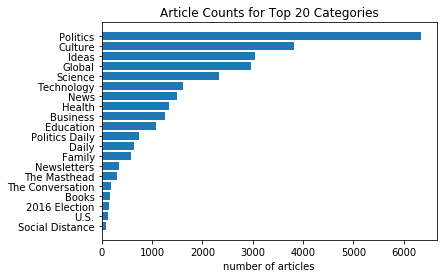

In [8]:
# number of articles by category
df_cat = df['category'].value_counts().reset_index()
df_cat_sorted = df_cat.sort_values('category')

# plot top 20 categories
plt.barh(df_cat_sorted['index'][-20:], df_cat_sorted['category'][-20:])
plt.title('Article Counts for Top 20 Categories')
plt.xlabel('number of articles')
plt.show()

Top categories by year...

In [9]:
# add column for year
df['year'] = df['date'].apply(lambda x: x.year)

In [10]:
top_10 = {} 

years = [2016, 2017, 2018, 2019, 2020]

for year in years:  
    # subset datframe for year
    df_year = df[df['year'] == year]
    
    # find top categories for year
    top10_year = dict(df_year['category'].value_counts()[:10])
    
    # add data to top_10 dictionary
    for category, count in top10_year.items():
        if category not in top_10:
            top_10[category] = {year: count}
        else:
            if year not in top_10[category]:
                top_10[category][year] = count  

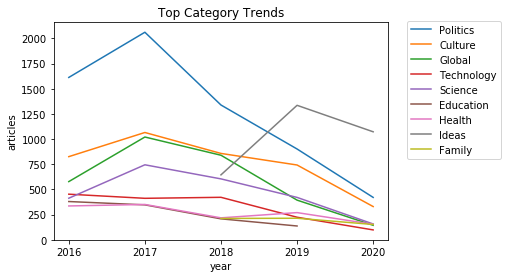

In [11]:
years = [2016, 2017, 2018, 2019, 2020]

# get years and values for top categories
for category, val in top_10.items():
    year = list(top_10[category].keys())
    count = list(top_10[category].values())
    
    # plot if more category appears in more than 2 years
    if len(year) > 2:
        plt.plot(year, count, label=str(category))

# add labels, etc.
plt.xticks(years)
plt.xlabel('year')
plt.ylabel('articles')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.03))
plt.title('Top Category Trends')
plt.show()

Looking into the lengths of articles:

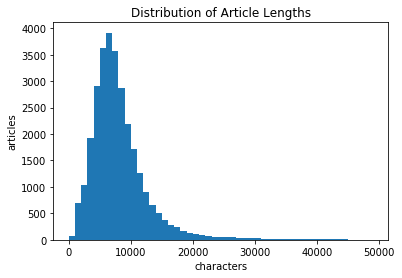

Length of longest article: 210770 characters
Length of shortest article: 208 characters


In [12]:
# use articles with text only
df_text = df.dropna(subset=['text'])

# maximum character value to plot
MAX_VAL = 50_000

plt.hist(df_text['text'].apply(len), bins=range(0, MAX_VAL, 1000))

plt.title('Distribution of Article Lengths')
plt.xlabel('characters')
plt.ylabel('articles')
plt.show()


# find lenghts of shortest/longest articles
longest = df_text['text'].apply(len).max()
shortest = df_text['text'].apply(len).min()
print(f'Length of longest article: {longest} characters')
print(f'Length of shortest article: {shortest} characters')

Number of articles published daily:

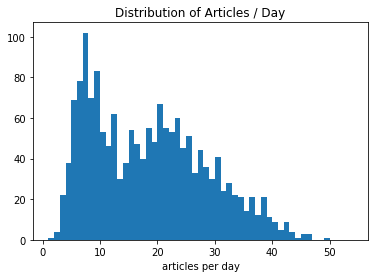

Number of articles per day
min: 1
max: 55
average: 18.01201201201201
median: 17.0


In [13]:
# find article count for each date
df_art = df['date'].value_counts().reset_index()

# plot distribution
plt.hist(df_art['date'], bins=range(min(df_art['date']), max(df_art['date'])))
plt.xlabel('articles per day')
plt.title('Distribution of Articles / Day')
plt.show()

# print summary stats
print('Number of articles per day')
print(f'min: {df_art["date"].min()}')
print(f'max: {df_art["date"].max()}')
print(f'average: {df_art["date"].mean()}')
print(f'median: {df_art["date"].median()}')

Checking whether this double curve may be due to the day of the week or the year:

In [14]:
def is_weekday(my_date):
    """Returns 'weekday' or 'weekend' based on whether a date
    is a weekday or not.
    
    Arguments:
    my_date -- date as a timestamp
    
    """
    weekday = '?'
    day_of_week = my_date.weekday()
    if day_of_week < 5:
        weekday = 'weekday'
    else:
        weekday = 'weekend'
    return weekday      

In [15]:
# new weekday column
df_art['weekday'] = df_art['index'].apply(is_weekday)

In [16]:
df_art['weekday'].value_counts()

weekday    1189
weekend     476
Name: weekday, dtype: int64

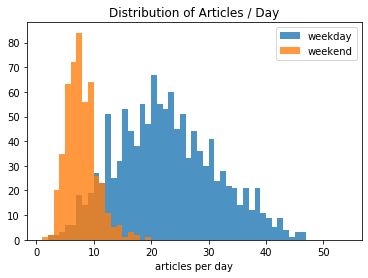

In [17]:
# plot distribution by weekday vs. weekend
for day in ['weekday', 'weekend']:
    #subset for day
    df_day = df_art[df_art['weekday'] == day]
    # plot distribution of articles
    plt.hist(
        df_day['date'], bins=range(min(df_day['date']), max(df_day['date'])), 
        label=day, alpha=0.8
    )

plt.xlabel('articles per day')
plt.title('Distribution of Articles / Day')
plt.legend()
plt.show()

Seeing if the number of articles published daily changes over the years:

In [18]:
df_art['year'] = df_art['index'].apply(lambda x: x.year)

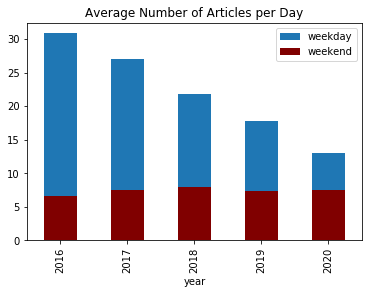

In [19]:
color_map = {
    'weekday': 'tab:blue',
    'weekend': 'maroon'
}

# subset for day and plot
for day, color in color_map.items():
    df_day = df_art[df_art['weekday'] == day]
    df_day.groupby('year')['date'].mean().plot(kind='bar', label=day, color=color)

plt.legend()
plt.title('Average Number of Articles per Day')
plt.show()

Are they employing fewer people?

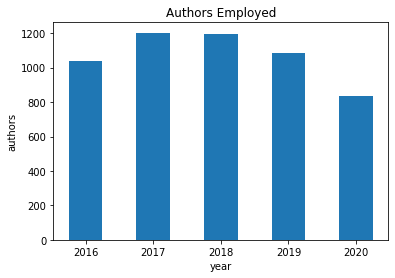

In [20]:
years = [2016, 2017, 2018, 2019, 2020]    
author_count = df.groupby('year')['author'].nunique().values

plt.bar(years, author_count, width=0.5)
plt.title('Authors Employed')
plt.xlabel('year')
plt.ylabel('authors')
plt.show()

An article:

In [21]:
df['text'][0]

' What We’re Following: Marching Toward JobsThe U.S. economy added a modest 215,000 jobs in March as the unemployment rate ticked upwards slightly to 5 percent, according to a Labor Department report Friday. Economists expect both wages and labor-force participation to climb as 2016 progresses.Second City Strike: Thousands of Chicago teachers went on a one-day strike Friday, grinding the third-largest school system in the country to a halt. Union officials launched the protest to urge Illinois Governor Bruce Rauner, a Republican, and his Democratic opponents to resolve a nine-month standoff over the state budget.Battery Included: Tesla Motors received over 115,000 preorders for its new Model 3 after CEO Elon Musk unveiled it on Thursday night, but customers have a long wait ahead: The first deliveries of the battery-powered sedan won’t be made until late 2017.SnapshotA man takes a picture of cherry blossoms in almost-full bloom in Tokyo, Japan, on April 1, 2016. See more of the week’s 

#### Cleaning the text

In [22]:
df_clean = df[df['text'].isna() == 0]
df_clean.shape

(29931, 10)

In [23]:
articles_lower = df_clean['text'].str.lower()

In [24]:
#articles_lower[0]

In [25]:
articles_lower = articles_lower.str.replace('\r', ' ')
articles_lower = articles_lower.str.replace('\n', ' ')
articles_lower = articles_lower.str.replace('|', '')

In [26]:
#articles_lower[0]

In [27]:
articles_tokenized = articles_lower.apply(lambda x: word_tokenize(x))

In [28]:
#articles_tokenized[0]

In [29]:
stemmer = PorterStemmer()
articles_stemmed = articles_tokenized.apply(
    lambda article: [stemmer.stem(word) for word in article]
)

In [30]:
#articles_stemmed[0]

In [31]:
stopwords_set = set(stopwords.words('english')) 
articles_cleaned = articles_stemmed.apply(
    lambda article: [word for word in article if word not in stopwords_set]
)

In [32]:
articles_cleaned = articles_cleaned.apply(
    lambda article: [word for word in article if word.isalpha()]
)

In [33]:
df_clean['cleaned_text'] = articles_cleaned.apply(lambda x: ' '.join(x))

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df_clean.to_pickle('data/atlantic_data.pkl')

In [35]:
df_clean.shape

(29931, 11)

The cleaned data will be used for sentiment analysis in 3.0_atlantic_sentiment_analysis.ipynb. 